In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import pygeohash as pgh
import ast
from collections import Counter
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Summary

### The code below is for the paper: Predicting AirBnb Prices and AirBnb Listing Availability

#### It is seperated into:
* Data processing (cleaning, feature engineering, and formatting)
* Modeling for Predicting AirBnb Prices
* Modeling for AirBnb Listing Availability

# Data Processing

In [4]:
df = pd.read_csv("listings.csv")

In [5]:
filt_df = df[["name", "host_is_superhost", "host_neighbourhood", "latitude", "longitude",
   "property_type", "room_type", "amenities", "price", "bedrooms",
   "beds", "review_scores_rating", 'availability_90']]

In [6]:
downtown_austin = (30.266666, -97.733330)

In [7]:
filt_df["dist_to_dt"] = filt_df.apply(lambda x: geodesic(downtown_austin, (x["latitude"], x["longitude"])).miles, axis=1)

<ipython-input-7-de5938311470>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df["dist_to_dt"] = filt_df.apply(lambda x: geodesic(downtown_austin, (x["latitude"], x["longitude"])).miles, axis=1)


<AxesSubplot:xlabel='dist_to_dt', ylabel='Count'>

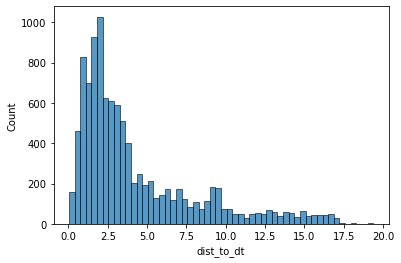

In [8]:
sns.histplot(filt_df["dist_to_dt"])

In [9]:
filt_df = filt_df[filt_df.dist_to_dt <= 5]

In [10]:
filt_df.price = filt_df.price.str.replace("$", "")
filt_df.price = filt_df.price.str.replace(",", "").astype(float)

<ipython-input-10-d46267ce030b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  filt_df.price = filt_df.price.str.replace("$", "")


In [11]:
filt_df.host_is_superhost = np.where(filt_df.host_is_superhost == "f", 0, 1)

In [12]:
filt_df.amenities = [ast.literal_eval(x) for x in filt_df.amenities]

In [295]:
filt_df.amenities 

0       [heating, lockbox, cable tv, microwave, dishwa...
1       [free parking on premises, dedicated workspace...
2       [heating, keypad, microwave, hangers, hot wate...
3       [washer, kitchen, tv, stove, wifi, cooking bas...
4       [lake access, fire extinguisher, free parking ...
                              ...                        
7372    [washer, kitchen, essentials, air conditioning...
7389    [washer, essentials, pool, private entrance, h...
7391    [kitchen, essentials, breakfast, air condition...
7417    [body soap, heating, keypad, single level home...
7422    [washer, kitchen, essentials, air conditioning...
Name: amenities, Length: 4369, dtype: object

In [13]:
all_amenities = []
for x in filt_df.amenities:
    all_amenities += x

In [14]:
amenities_dict = dict(Counter(all_amenities))

In [15]:
filt_df = filt_df[filt_df.price>=15]

In [16]:
filt_df.reset_index(inplace=True, drop=True)

In [17]:
amenities_prices = {}
for a in amenities_dict.keys():
    amenities_price = []
    i = 0
    for listing in filt_df.amenities:
        if a in listing:
            price = filt_df.loc[i, "price"]
        amenities_price.append(price)
        i+=1
    amenities_prices[a] = np.mean(amenities_price)

In [18]:
amenities_prices = dict(sorted(amenities_prices.items(), key=lambda item: item[1]))

In [19]:
filt_amenities = ["pool", "baby", "barbeque", "hot tub", "pets", "fire"]

In [20]:
lower_amenities = []
for amenities in filt_df.amenities:
    amen = [x.lower() for x in amenities]
    lower_amenities.append(amen)

In [21]:
filt_df.amenities = lower_amenities

In [22]:
all_amenities = []
for al in filt_df.amenities:
    listing_amen = []
    for a in al:
        for fa in filt_amenities:
            if fa in a:
                listing_amen.append(fa)
    all_amenities.append(listing_amen)

In [23]:
filt_df['filt_amenitites'] = all_amenities

In [24]:
amen_dummies = filt_df['filt_amenitites'].str.join('|').str.get_dummies().add_prefix('amenitites_')

In [25]:
filt_df=pd.concat([filt_df, amen_dummies], axis=1)

In [26]:
filt_df["num_amenities"] = [len(x) for x in filt_df.amenities]

In [27]:
filt_df.drop_duplicates(subset="name", inplace=True)

In [28]:
filt_df = filt_df[~(filt_df.host_neighbourhood.isna())]

In [29]:
filt_df = filt_df[~(filt_df.review_scores_rating.isna())]

In [30]:
filt_df["geohash"] = filt_df.apply(lambda x: pgh.encode(x["latitude"], x["longitude"], precision=5), axis=1)

In [31]:
geos = filt_df.groupby("geohash")["price"].count() > 30

In [32]:
filt_df = filt_df[filt_df.geohash.isin(geos[geos.values].index)]

In [33]:
prop_type = filt_df.groupby("property_type")["name"].count().sort_values()

In [34]:
allowed_prop_type = prop_type[prop_type > 100].index

In [35]:
filt_df = filt_df[filt_df.property_type.isin(allowed_prop_type)]

In [36]:
filt_df.bedrooms.fillna(0, inplace=True)

In [37]:
filt_df = filt_df[filt_df.price <9999]

In [38]:
filt_df["bedroom_cat"] = np.where(filt_df.bedrooms == 1, "one",
        np.where(filt_df.bedrooms == 2, "two",
                np.where(filt_df.bedrooms == 3, "three",
                        np.where(filt_df.bedrooms > 3, "greater_than_3", "zero"))))

In [39]:
filt_df["log_price"] = np.log(filt_df.price)

<AxesSubplot:xlabel='property_type'>

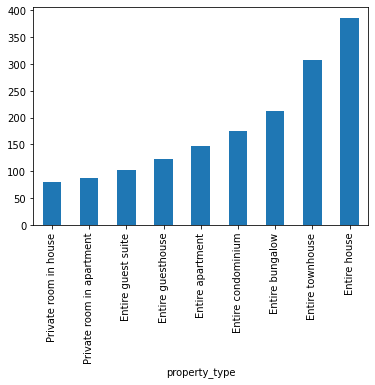

In [40]:
filt_df.groupby("property_type")["price"].mean().sort_values().plot(kind="bar")

<AxesSubplot:xlabel='geohash'>

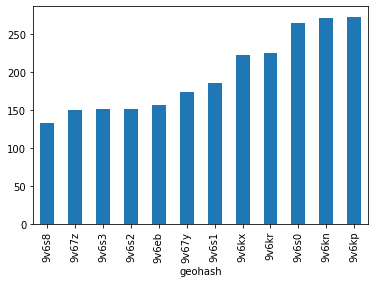

In [41]:
filt_df.groupby("geohash")["price"].mean().sort_values().plot(kind="bar")

<AxesSubplot:xlabel='bedroom_cat'>

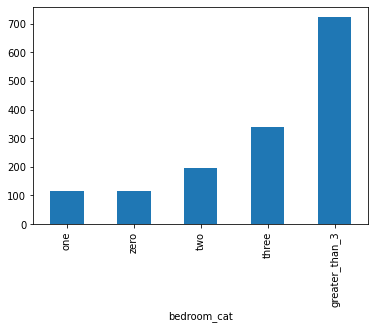

In [42]:
filt_df.groupby("bedroom_cat")["price"].mean().sort_values().plot(kind="bar")

Text(0.5, 0.98, 'Categorical Features')

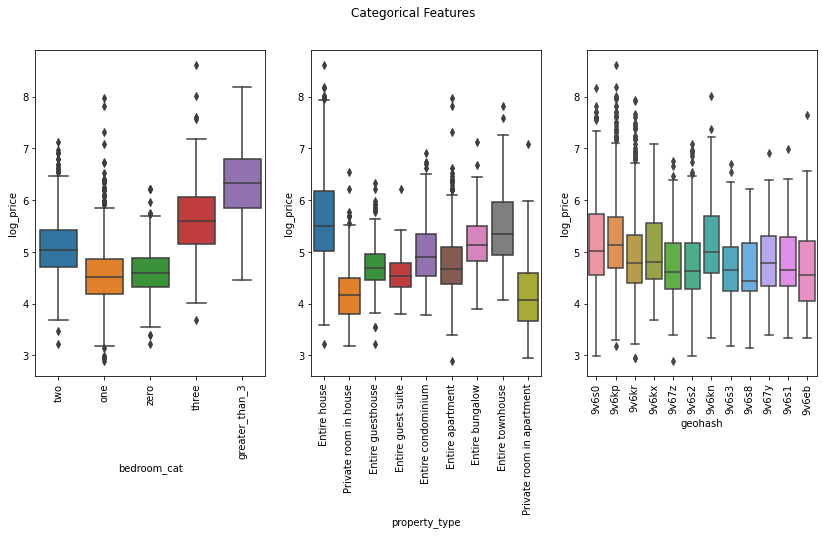

In [43]:
fig, axes = plt.subplots(figsize=(14, 6),ncols=3)
sns.boxplot(x="bedroom_cat", y="log_price", data=filt_df, ax=axes[0])
sns.boxplot(x="property_type", y="log_price", data=filt_df, ax=axes[1])
sns.boxplot(x="geohash", y="log_price", data=filt_df, ax=axes[2])
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
fig.suptitle("Categorical Features")

<AxesSubplot:xlabel='geohash', ylabel='log_price'>

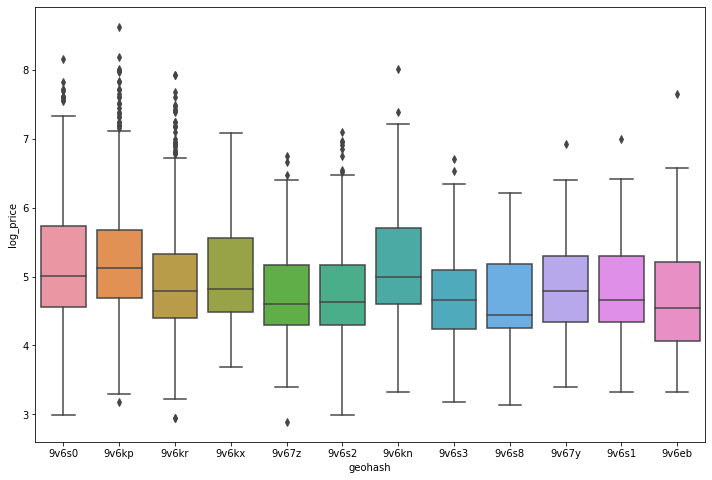

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x="geohash", y="log_price", data=filt_df)

In [45]:
prop_type_df = pd.get_dummies(filt_df.property_type, prefix="prop_")
geohash_df = pd.get_dummies(filt_df.geohash, prefix="geohash_")
bedroom_df = pd.get_dummies(filt_df.bedroom_cat, prefix="bedroom_")

Text(0.5, 0.98, 'Numerical Features')

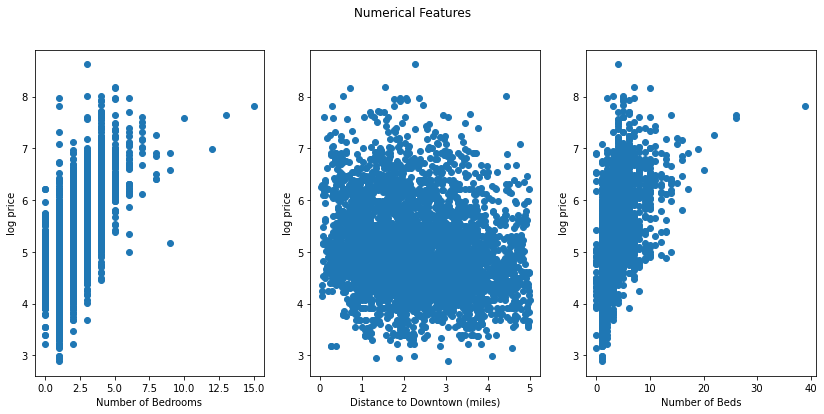

In [46]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=3)
axes[0].scatter(filt_df.bedrooms, filt_df.log_price)
axes[1].scatter(filt_df.dist_to_dt, filt_df.log_price)
axes[2].scatter(filt_df.beds, filt_df.log_price)
axes[0].set_xlabel("Number of Bedrooms")
axes[1].set_xlabel("Distance to Downtown (miles)")
axes[2].set_xlabel("Number of Beds")
axes[0].set_ylabel("log price")
axes[1].set_ylabel("log price")
axes[2].set_ylabel("log price")
fig.suptitle("Numerical Features")

In [912]:
final_df = filt_df[["name", 'host_is_superhost', 'price',
       'bedrooms', 'beds', 'review_scores_rating', 'availability_90',
       'dist_to_dt', 'amenitites_baby',
       'amenitites_barbeque', 'amenitites_fire', 'amenitites_hot tub',
       'amenitites_pets', 'amenitites_pool', 'log_price']]

In [913]:
final_df = pd.concat([final_df, prop_type_df, geohash_df, bedroom_df],axis=1)

In [914]:
final_df = final_df[final_df.price < 9999]

In [915]:
scaler = StandardScaler()

In [916]:
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoiY29keWdyZWNvIiwiYSI6ImNrbDVsancxdDI0enEycHBsMXl3eG9lNGYifQ._GaFrtS_NTrW7xcNs5w8Aw")
fig = px.scatter_mapbox(filt_df, lat="latitude", lon="longitude", color="log_price",
                  color_continuous_scale=px.colors.diverging.RdYlGn, size_max=15, zoom=10)
fig.show()

In [917]:
final_df["price_bin"] = pd.qcut(final_df.price,q=3, labels=["cheap", "average", "high"])

In [918]:
final_df["price_bin"] = final_df["price_bin"].cat.codes

In [919]:
lawl= pd.qcut(final_df.price,q=3)

In [920]:
set(lawl)

{Interval(17.999, 100.0, closed='right'),
 Interval(100.0, 198.0, closed='right'),
 Interval(198.0, 5550.0, closed='right')}

In [921]:
final_df.fillna(0, inplace=True)
X = final_df[final_df.columns[1:]]
X = X.drop(["price", "log_price", "price_bin"], axis=1)
X = scaler.fit_transform(X)
y = final_df.price_bin

In [922]:
problem_one = final_df.copy()

In [923]:
from sklearn.mixture import GaussianMixture as GMM

In [58]:
clusters =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40]

In [59]:
SEED=182371283

In [698]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)

In [61]:
import time

In [355]:
import os
from functools import reduce

import pandas as pd
import numpy as np

from collections import Counter
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from collections import defaultdict
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, silhouette_samples, homogeneity_score, completeness_score, v_measure_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture as GMM



def cluster_accuracy(y, cluster_labels):
    assert (y.shape == cluster_labels.shape)
    pred = np.empty_like(y)
    for label in set(cluster_labels):
        mask = cluster_labels == label
        sub = y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return accuracy_score(y, pred)

clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
clustering_metrics = {"homogeneity_score": homogeneity_score,
                      "completeness_score": completeness_score,
                      "v_measure_score": v_measure_score,
                      "adjusted_mutual_info_score": adjusted_mutual_info_score,
                      "cluster_accuracy_score": cluster_accuracy}

def run_clustering(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
    kmeans_dfs = [] 
    gmm_dfs = []
    km = kmeans(random_state=SEED, init="k-means++", n_init=4)
    gmm = GMM(random_state=SEED, init_params="kmeans", n_init=4)
    for k in clusters:
        km.set_params(n_clusters=k)
        gmm.set_params(n_components=k)
        km.fit(X_train)
        gmm.fit(X_train)

        km_labels = km.predict(X_train)
        gmm_labels = gmm.predict(X_train)

        kmeans_res = {k:v(y_train, km_labels) for (k,v) in clustering_metrics.items()}
        gmm_res = {k:v(y_train, gmm_labels) for (k,v) in clustering_metrics.items()}
        kmeans_res["silhouette_score"] = silhouette_score(X_train, km_labels)
        gmm_res["silhouette_score"] = silhouette_score(X_train, gmm_labels)
        kmeans_df = pd.DataFrame(kmeans_res, index=["k={0}".format(k)])
        gmm_df = pd.DataFrame(gmm_res, index=["k={0}".format(k)])
        gmm_dfs.append(gmm_df)
        kmeans_dfs.append(kmeans_df)
    kmeans_df = pd.concat(kmeans_dfs)
    gmm_df = pd.concat(gmm_dfs)
    return kmeans_df, gmm_df

In [63]:
kmeans_df, gmm_df = run_clustering(X, y)

In [361]:
def plot_results(results_df):
    fig, axes = plt.subplots(figsize=(14, 4), ncols=6, nrows=1)
    for i, j in enumerate(results_df.columns):
        max_val = np.argmax(results_df[j])
        max_idx = results_df[j].index[max_val]
        axes[i].plot(results_df.index, results_df[j], marker="o")
        axes[i].set_ylabel(j)
        axes[i].set_title("{0}".format(j.replace("_", " ")))
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(45)
        axes[i].axvline(max_idx, ls="--", color="black")
    fig.tight_layout()
    

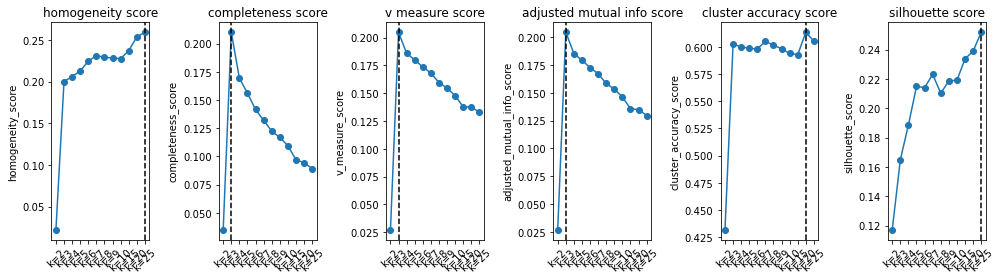

In [293]:
plot_results(kmeans_df)

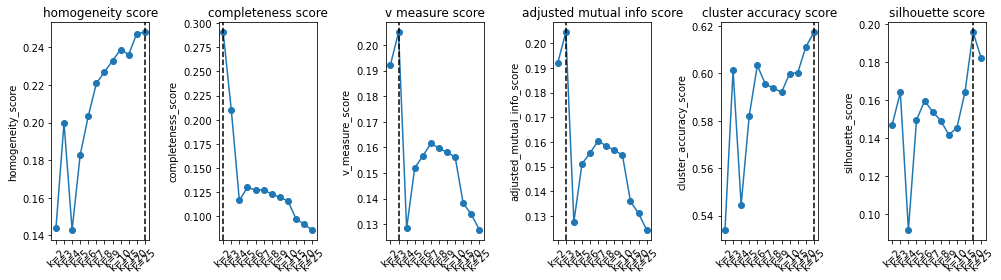

In [294]:
plot_results(gmm_df)

In [67]:
km = kmeans(n_clusters=4, random_state=SEED, init="k-means++", n_init=4)
gmm = GMM(n_components=2, random_state=SEED, n_init=4)

In [372]:
def inspect_kmeans(algo, X):
    inspect_df = X.copy(deep=True)
    algo.fit(X)
    X_dist = algo.transform(X)**2
    label = algo.predict(X)
    inspect_df["kmeans_label"] = label
    center_dists = np.array([X_dist[i][x] for i,x in enumerate(label)])
    inspect_df["dist_to_cluster"] = center_dists
    inspect_df["label"] = label
    inspect_df.groupby("kmeans_label").dist_to_cluster.sum().plot(kind="bar",
                                                                  xlabel="Cluster Number",
                                                                 ylabel="Sum of Distances",
                                                                 title="Total Distance to Cluster Centroid (K-Means)")
    min_indices = []
    for l in np.unique(algo.labels_):
        X_label_indices = np.where(label==l)[0]
        min_label_idx = X_label_indices[np.argmin(center_dists[label==l])]
        min_indices.append(min_label_idx)
    min_idx_dfs = []
    for idx in min_indices:
        col_name = inspect_df.iloc[idx, :]["kmeans_label"]
        min_idx_df = pd.Series(inspect_df.iloc[idx, :],name=col_name)
        min_idx_dfs.append(pd.DataFrame(min_idx_df))
    min_idx_df = pd.concat(min_idx_dfs,axis=1)
    min_norm_idx_df = pd.DataFrame(scaler.fit_transform(min_idx_df.iloc[1:-3, :]), index=min_idx_df.index[1:-3])
    most_var_cols = min_norm_idx_df.var(axis=1).sort_values(ascending=False)[:6].index
    print(min_idx_df[min_idx_df.index.isin(most_var_cols)])
    print(inspect_df.groupby("kmeans_label")[most_var_cols].mean())

                          0      1      2      3
price                 116.0  490.0  116.0  122.0
bedrooms                0.0    3.0    1.0    2.0
beds                    1.0    6.0    2.0    2.0
review_scores_rating   99.0   99.0   96.0   98.0
availability_90          34     42     36     39
bedroom__three            0      1      0      0
              review_scores_rating       price  availability_90  bedrooms  \
kmeans_label                                                                
0                        97.107335  122.352415        35.651163  0.520572   
1                        96.676525  493.849353        38.316081  3.654344   
2                        95.463759  115.055283        27.101966  1.000000   
3                        96.022727  194.944545        29.233636  2.000000   

                  beds  bedroom__three  
kmeans_label                            
0             1.441860        0.000000  
1             5.260628        0.597043  
2             1.290541        

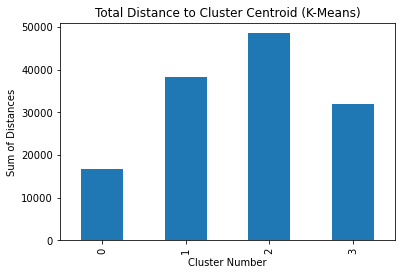

In [72]:
inspect_kmeans(km, X)

In [74]:
def inspect_gmm(gmm, X):
    inspect_df = final_df.copy(deep=True)
    gmm.fit(X)
    min_indices = []
    inspect_df["gmm_label"] = gmm.predict(X)
    centers = np.empty(shape=(gmm.n_components, X.shape[1]))
    for i in range(gmm.n_components):
        density = multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
        centers[i, :] = X[np.argmax(density)]
    for i in range(gmm.n_components):
        min_dist = 1
        min_idx = 0
        for j in range(X.shape[0]):
            dist = mahalanobis(centers[i], X[j], inv(gmm.covariances_[i]))
            if (dist < min_dist):
                min_dist = dist
                min_idx = j
        min_indices.append(min_idx)
    ttl_distances = []
    for i in range(gmm.n_components):
        ttl_distances.append(
            sum([mahalanobis(centers[i], x, inv(gmm.covariances_[i])) for x in X[np.array(inspect_df.gmm_label == i)]])
        )
    plt.bar(x=["Cluster 0", "Cluster 1"], height=ttl_distances)
    plt.xlabel("Cluster Number")
    plt.ylabel("Sum of Distances")
    plt.title("Total Distance to Cluster Centroid (EM)")
    min_idx_dfs = []
    for idx in min_indices:
        col_name = inspect_df.iloc[idx, :]["gmm_label"]
        min_idx_df = pd.Series(inspect_df.iloc[idx, :],name=col_name)
        min_idx_dfs.append(pd.DataFrame(min_idx_df))
    min_idx_df = pd.concat(min_idx_dfs,axis=1)
    min_norm_idx_df = pd.DataFrame(scaler.fit_transform(min_idx_df.iloc[1:-3, :]), index=min_idx_df.index[1:-3])
    most_var_cols = min_norm_idx_df.var(axis=1).sort_values(ascending=False)[:6].index
    print(min_idx_df[min_idx_df.index.isin(most_var_cols)])
    print(inspect_df.groupby("gmm_label")[most_var_cols].mean())

                         0      1
price                 48.0  144.0
beds                   1.0    4.0
review_scores_rating  95.0   95.0
availability_90         15     34
amenitites_pool          1      0
bedroom__one             1      0
                price  review_scores_rating  availability_90      beds  \
gmm_label                                                                
0          122.751716             95.653210        29.395236  1.463868   
1          370.207717             96.719873        34.278013  4.118922   

           amenitites_pool  bedroom__one  
gmm_label                                 
0                 0.317723      0.740008  
1                 0.166490      0.000000  


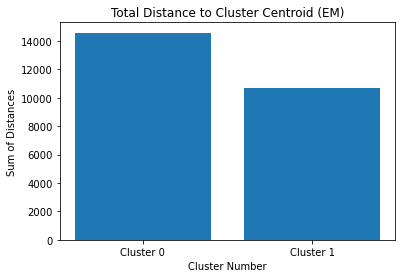

In [75]:
inspect_gmm(gmm, X)

In [76]:
from sklearn.decomposition import FastICA, PCA
from sklearn.random_projection import GaussianRandomProjection

In [77]:
#do wrapping and do filtering

In [78]:
n_components = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]

In [79]:
from sklearn.linear_model import LogisticRegressionCV

In [929]:
def run_dim_reduction(X, y):
    pca_dfs, ica_dfs, rp_dfs = [], [], []
    rds = {"PCA": PCA(random_state=SEED),
          "RP": GaussianRandomProjection(random_state=SEED),
          "ICA": FastICA(random_state=SEED, max_iter=1000, tol=.1),
          "FA": FactorAnalysis(random_state=SEED)}
    lr = LogisticRegressionCV(solver='liblinear', random_state=SEED)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
    lr.fit(X_train, y_train.values)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    dfs = []
    for k in range(2, 26):
        results = {}
        for name, rd in rds.items():
            rd.set_params(n_components=k)
            X_rd = rd.fit_transform(X)
            X_train, X_test, y_train, y_test = train_test_split(X_rd, y, test_size=.33, random_state=SEED)
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            result_df = pd.DataFrame(results, index=["n_components={0}".format(k)])
        dfs.append(result_df)
    results_df = pd.concat(dfs)
    results_df["All Data"] = [acc]*len(results_df)
    return results_df

In [930]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)

In [931]:
results_df = run_dim_reduction(X, y)

In [932]:
results_df.index = [x[1] for x in results_df.index.str.split("=")]

Text(0.5, 1.0, 'Logistic Regression Accuracy on Projected Data')

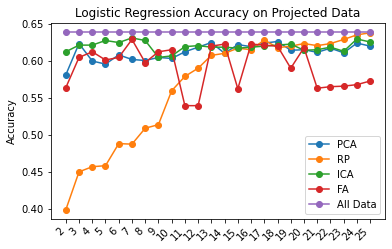

In [933]:
fig, ax = plt.subplots(figsize=(6, 4))
for col in results_df.columns:
    ax.plot(results_df[[col]], label=col, marker='o')
fig.autofmt_xdate(rotation=45)
ax.legend()
ax.set_ylabel("Accuracy")
ax.set_title("Logistic Regression Accuracy on Projected Data")

In [153]:
n_components = np.arange(2, 25)

In [154]:
ica = FastICA(random_state=SEED, max_iter=1000, tol=.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
kurts = {}
for k in n_components:
    ica.set_params(n_components=k)
    tmp = ica.fit_transform(X_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurts[k] = tmp.abs().mean()
    
plt.bar(x=kurts.keys(), height=kurts.values())
plt.title('Kurtosis by Component (ICA)')
plt.xlabel("Number of components")
plt.ylabel('Kurtosis')

Text(0, 0.5, 'Kurtosis')

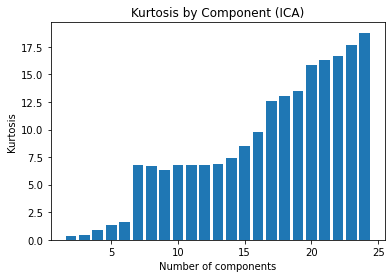

In [167]:
plt.bar(x=kurts.keys(), height=kurts.values())
plt.title('Kurtosis by Component (ICA)')
plt.xlabel("Number of components")
plt.ylabel('Kurtosis')

In [170]:
pca = PCA(n_components=X.shape[1], random_state=SEED)
pca.fit(X_train)

PCA(n_components=38, random_state=182371283)

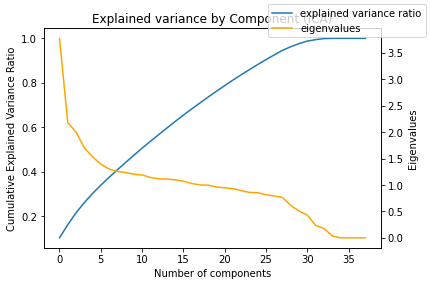

In [196]:
pca = PCA(n_components=X.shape[1], random_state=SEED)
pca.fit(X_train)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(np.arange(0, X.shape[1]), np.cumsum(pca.explained_variance_ratio_), label="explained variance ratio")
ax2.plot(np.arange(0, X.shape[1]), pca.explained_variance_, label="eigenvalues", color="orange")
ax.set_title('Explained variance by Component (ICA)')
ax.set_xlabel("Number of components")
ax.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_ylabel('Eigenvalues')
fig.legend()
fig.tight_layout()

In [87]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [90]:
from sklearn.metrics.pairwise import euclidean_distances

In [896]:
from sklearn.decomposition import FactorAnalysis

In [900]:
def plot_distance_rates(X):
    rds = {"PCA": PCA(random_state=SEED),
          "RP": GaussianRandomProjection(random_state=SEED),
          "ICA": FastICA(random_state=SEED, max_iter=1000, tol=1),
          "FA": FactorAnalysis(random_state=SEED)}
    n_components = [2, 8, X.shape[1]]
    dists = euclidean_distances(X, squared=True).ravel()
    nonzero = dists != 0
    dists = dists[nonzero]
    for name, rd in rds.items():
        fig, axes = plt.subplots(figsize=(12, 4), ncols=3, nrows=1)
        for i, k in enumerate(n_components):
            rp = rd.set_params(n_components=k)
            projected_data = rp.fit_transform(X)
            projected_dists = euclidean_distances(
                projected_data, squared=True).ravel()[nonzero]
            rates = projected_dists / dists
            if i <= 2:
                axes[i].hist(rates, bins=50, density=True)
                axes[i].set_xlabel("Squared distances rate: projected / original")
                axes[i].set_ylabel("Distribution of samples pairs")
                axes[i].set_title("for n_components={0}\n mean:{1}\n std: {2}".format(
                    k,
                    round_sig(np.mean(rates)),
                    round_sig(np.std(rates))))
            else:
                axes[1, i%4].hist(rates, bins=50, density=True)
                axes[1, i%4].set_xlabel("Squared distances rate: projected / original")
                axes[1, i%4].set_ylabel("Distribution of samples pairs")
                axes[1, i%4].set_title("for n_components={0}\n mean:{1}\n std: {2}".format(
                    k,
                    round_sig(np.mean(rates)),
                    round_sig(np.std(rates))))
        fig.suptitle("Histogram of pairwise distance rates using {0}".format(name))
        fig.tight_layout()

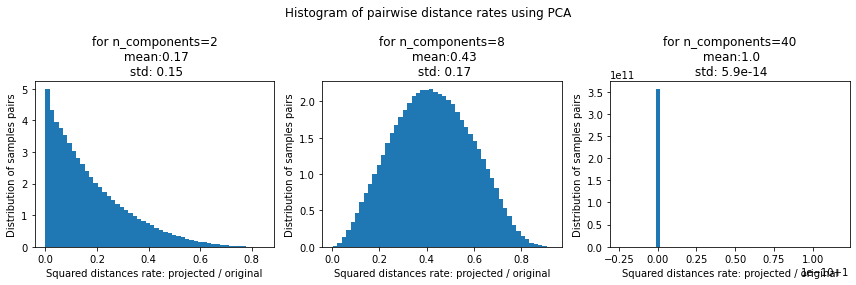

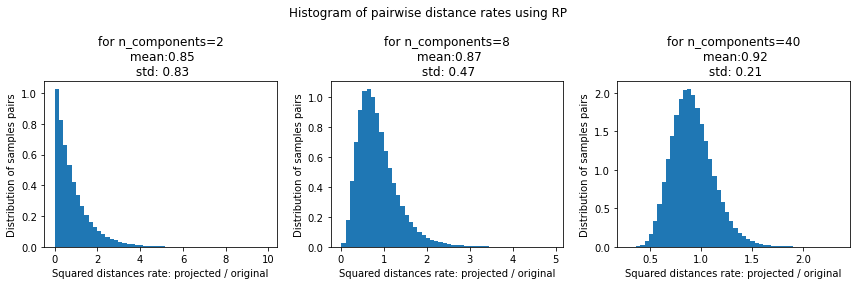

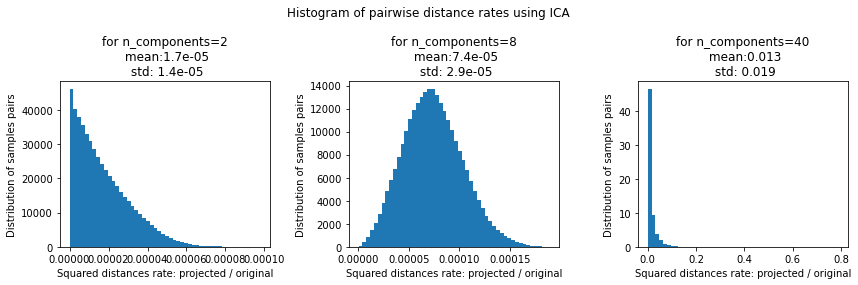

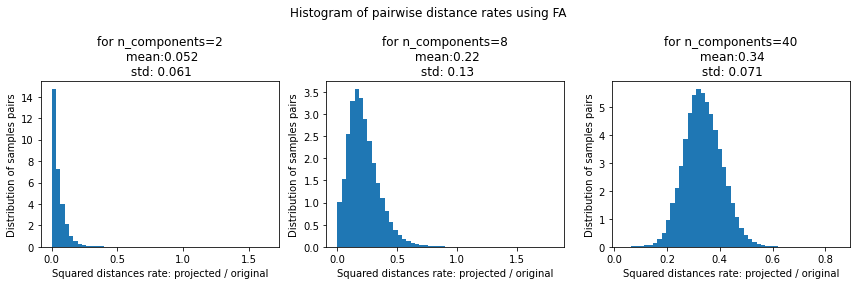

In [901]:
plot_distance_rates(X_train)

In [126]:
X[:, 7]

array([0., 0., 0., ..., 0., 0., 0.])

Text(33.0, 0.5, 'Feature Number')

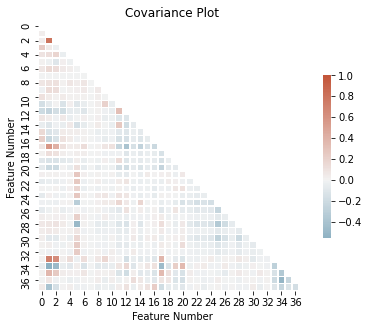

In [138]:
d = pd.DataFrame(X)

# Compute the correlation matrix
corr = d.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Covariance Plot")
ax.set_xlabel("Feature Number")
ax.set_ylabel("Feature Number")

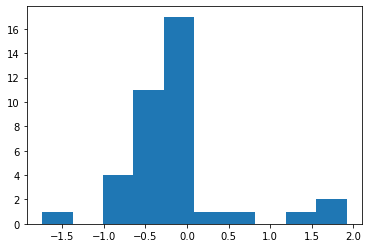

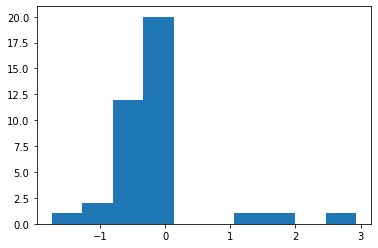

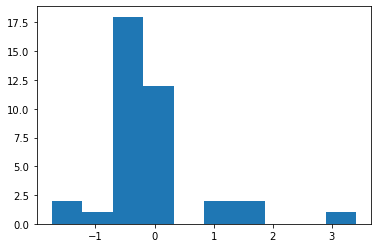

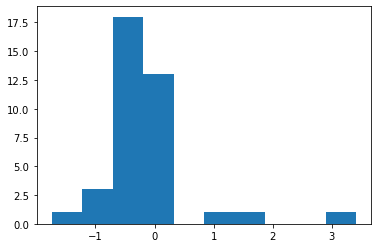

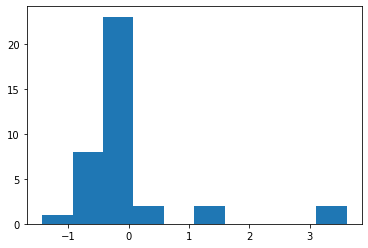

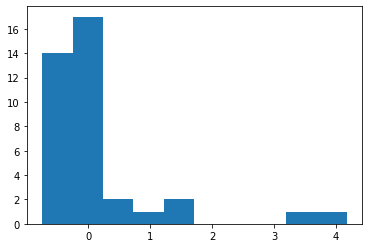

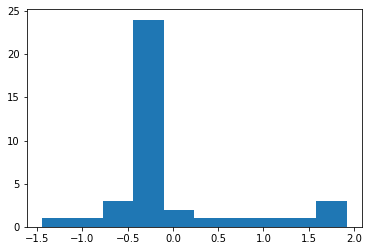

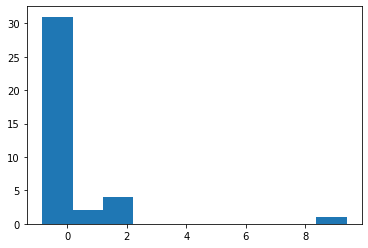

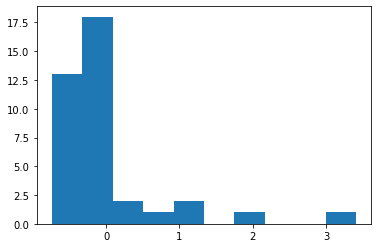

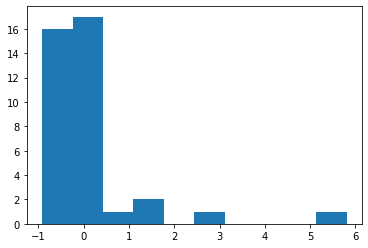

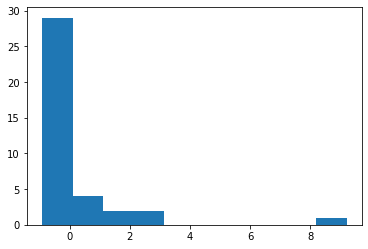

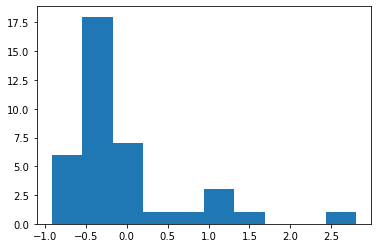

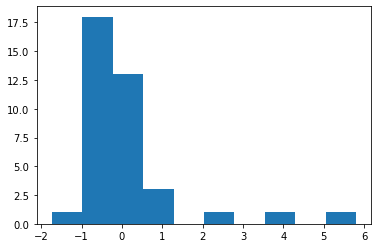

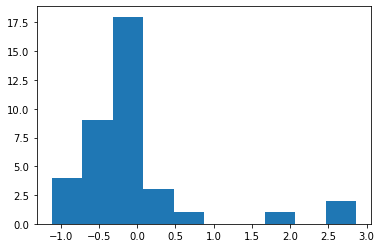

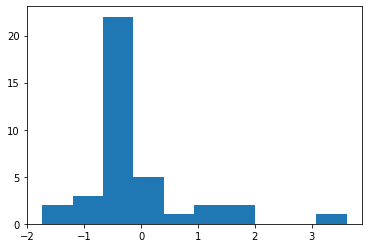

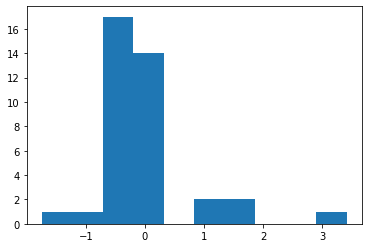

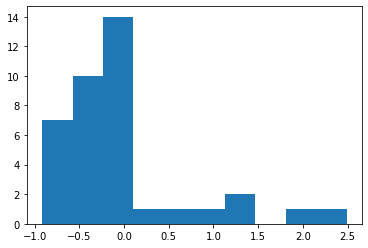

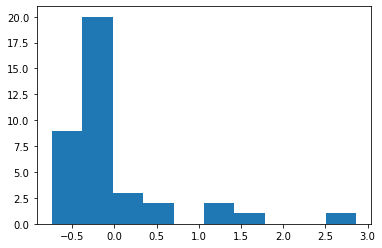

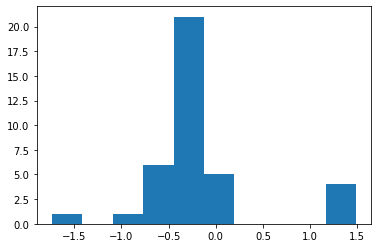

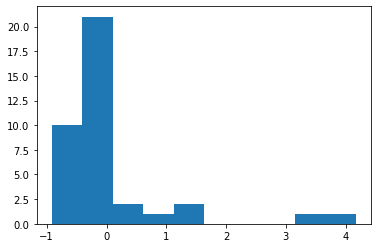

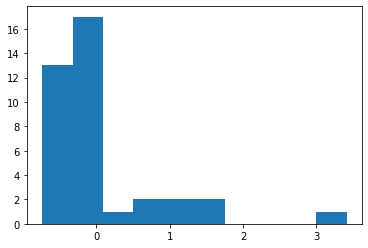

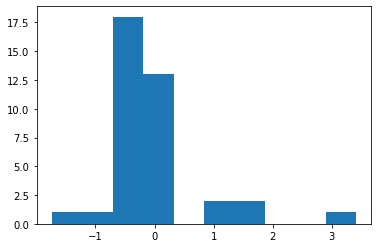

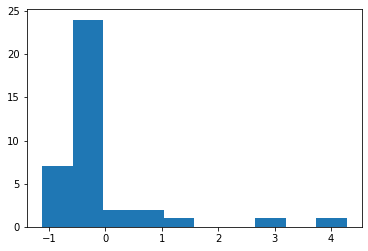

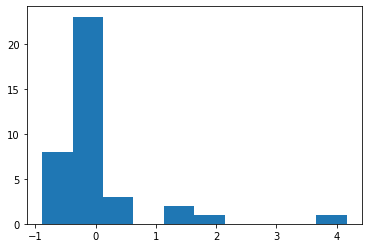

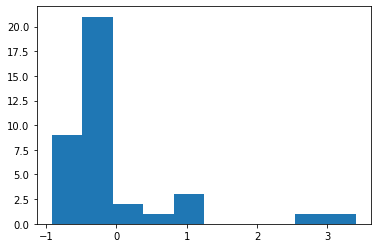

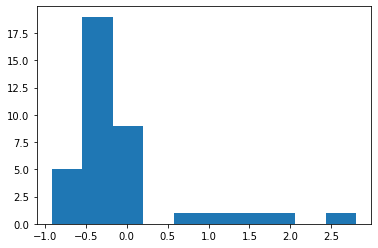

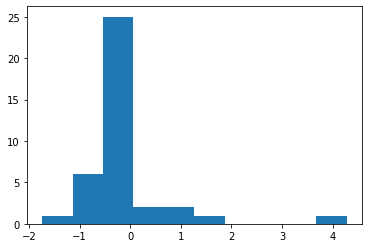

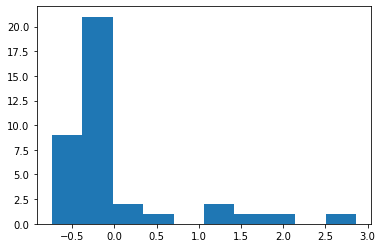

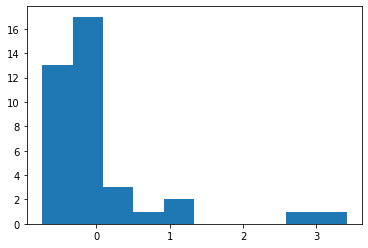

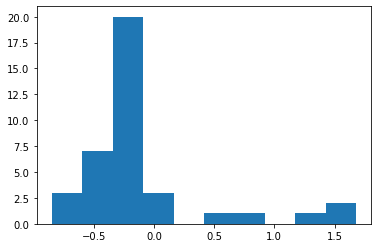

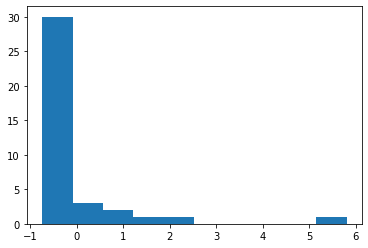

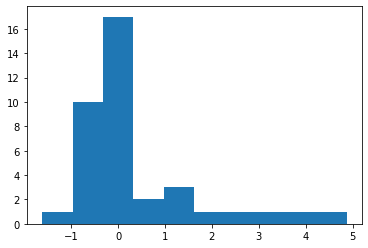

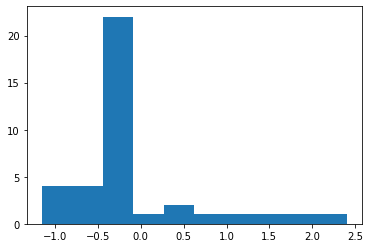

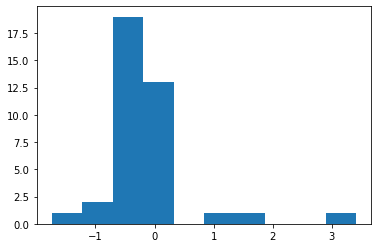

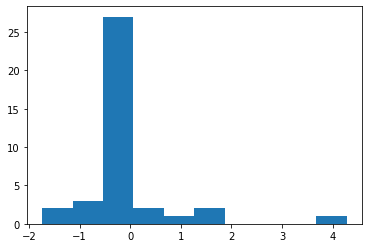

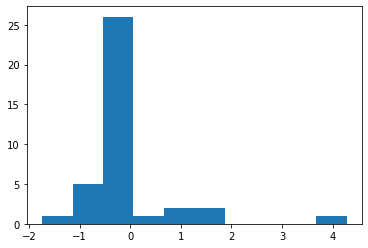

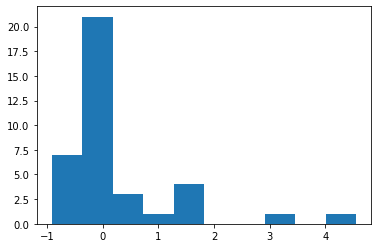

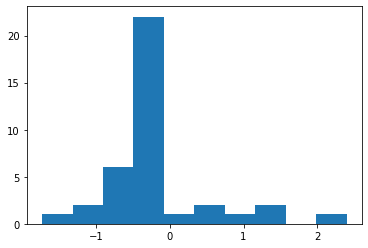

In [136]:
for i in range(X.shape[1]):
    plt.hist(X[i])
    plt.show()

In [209]:
clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]

In [212]:
projected_data.shape

(4369, 8)

In [213]:
y

array([0.50706926, 0.2645238 , 0.55660384, 0.77416061, 0.60785977])

In [216]:
    rds = {"PCA": PCA(random_state=SEED),
          "RP": GaussianRandomProjection(random_state=SEED),
          "ICA": FastICA(random_state=SEED, max_iter=1000, tol=1)}
    n_components = [2, 8, X.shape[1]]
    dists = euclidean_distances(X, squared=True).ravel()
    nonzero = dists != 0
    dists = dists[nonzero]
    all_km_dfs = []
    all_gmm_dfs = []
    for name, rd in rds.items():
        rp = rd.set_params(n_components=8)
        projected_data = rp.fit_transform(X)
        kmeans_dfs = []
        gmm_dfs = []
        for n in clusters:
            X_train, X_test, y_train, y_test = train_test_split(projected_data, y, test_size=.33, random_state=SEED)
            kmeans_dfs = [] 
            gmm_dfs = []
            km = kmeans(random_state=SEED, init="k-means++", n_init=4)
            gmm = GMM(random_state=SEED, init_params="kmeans", n_init=4)
            for k in clusters:
                km.set_params(n_clusters=k)
                gmm.set_params(n_components=k)
                km.fit(X_train)
                gmm.fit(X_train)

                km_labels = km.predict(X_train)
                gmm_labels = gmm.predict(X_train)

                kmeans_res = {k:v(y_train, km_labels) for (k,v) in clustering_metrics.items()}
                gmm_res = {k:v(y_train, gmm_labels) for (k,v) in clustering_metrics.items()}
                kmeans_res["silhouette_score"] = silhouette_score(X_train, km_labels)
                gmm_res["silhouette_score"] = silhouette_score(X_train, gmm_labels)
                kmeans_df = pd.DataFrame(kmeans_res, index=["k={0}".format(k)])
                gmm_df = pd.DataFrame(gmm_res, index=["k={0}".format(k)])
                gmm_dfs.append(gmm_df)
                kmeans_dfs.append(kmeans_df)
        gmm_df = pd.concat(gmm_dfs)
        kmeans_df = pd.concat(kmeans_dfs)
        gmm_df["dim_red"] = name
        kmeans_df["dim_red"] = name
        all_km_dfs.append(kmeans_df)
        all_gmm_dfs.append(gmm_df)

ERROR! Session/line number was not unique in database. History logging moved to new session 533


In [219]:
all_km_df = pd.concat(all_km_dfs)
all_gmm_df = pd.concat(all_gmm_dfs)

In [ ]:
def plot_results(results_df):
    fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)
    for i, j in enumerate(results_df.columns):
        if i <= 2:
            max_val = np.argmax(results_df[j])
            max_idx = results_df[j].index[max_val]
            axes[0, i].plot(results_df.index, results_df[j], marker="o")
            axes[0, i].set_ylabel(j)
            axes[0, i].set_title("{0}s for different K".format(j.replace("_", " ")))
            for tick in axes[0, i].get_xticklabels():
                tick.set_rotation(45)
            axes[0, i].axvline(max_idx, ls="--", color="black")
        else:
            max_val = np.argmax(results_df[j])
            max_idx = results_df[j].index[max_val]
            axes[1, i%3].plot(results_df.index, results_df[j])
            axes[1, i%3].set_ylabel(j)
            axes[1, i%3].set_title("{0}s for different K".format(j.replace("_", " ")))
            for tick in axes[1, i%3].get_xticklabels():
                tick.set_rotation(45)
            axes[1, i%3].axvline(max_idx, ls="--", color="black")
    fig.tight_layout()
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


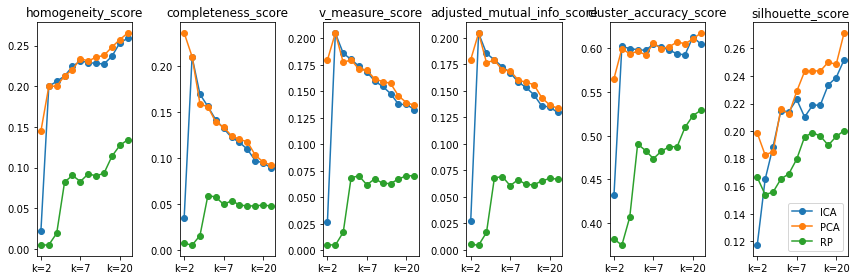

In [255]:
all_km_df = pd.concat(all_km_dfs)
all_gmm_df = pd.concat(all_gmm_dfs)

fig, axes = plt.subplots(ncols=6, figsize=(12, 4))
for i, score in enumerate(all_km_df.columns[:-1]):
    for dim_red in ["ICA", "PCA", "RP"]:
        all_km_df[all_km_df.dim_red == dim_red][score].plot(label=dim_red, marker="o", ax=axes[i])
        plt.legend()
        axes[i].set_title(score)
fig.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


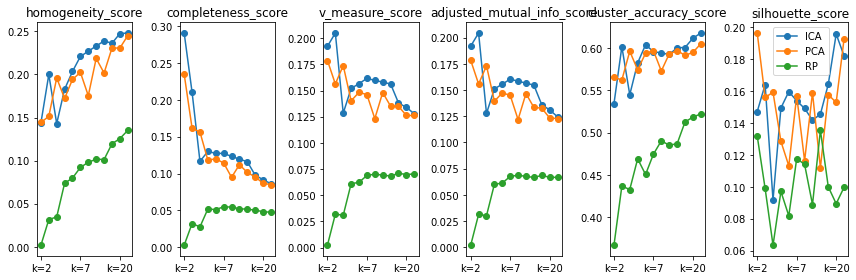

In [258]:
fig, axes = plt.subplots(ncols=6, figsize=(12, 4))
for i, score in enumerate(all_km_df.columns[:-1]):
    for dim_red in ["ICA", "PCA", "RP"]:
        all_gmm_df[all_gmm_df.dim_red == dim_red][score].plot(label=dim_red, marker="o", ax=axes[i])
        plt.legend()
        axes[i].set_title(score)
fig.tight_layout()

In [267]:
def inspect_gmm(gmm, X):
    inspect_df = final_df.copy(deep=True)
    gmm.fit(X)
    min_indices = []
    inspect_df["gmm_label"] = gmm.predict(X)
    centers = np.empty(shape=(gmm.n_components, X.shape[1]))
    for i in range(gmm.n_components):
        density = multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
        centers[i, :] = X[np.argmax(density)]
    for i in range(gmm.n_components):
        min_dist = 1
        min_idx = 0
        for j in range(X.shape[0]):
            dist = mahalanobis(centers[i], X[j], inv(gmm.covariances_[i]))
            if (dist < min_dist):
                min_dist = dist
                min_idx = j
        min_indices.append(min_idx)
    ttl_distances = []
    for i in range(gmm.n_components):
        ttl_distances.append(
            sum([mahalanobis(centers[i], x, inv(gmm.covariances_[i])) for x in X[np.array(inspect_df.gmm_label == i)]])
        )
    plt.bar(x=["Cluster 0", "Cluster 1", "Cluster 2"], height=ttl_distances)
    plt.xlabel("Cluster Number")
    plt.ylabel("Sum of Distances")
    plt.title("Total Distance to Cluster Centroid (EM)")
    min_idx_dfs = []
    for idx in min_indices:
        col_name = inspect_df.iloc[idx, :]["gmm_label"]
        min_idx_df = pd.Series(inspect_df.iloc[idx, :],name=col_name)
        min_idx_dfs.append(pd.DataFrame(min_idx_df))
    min_idx_df = pd.concat(min_idx_dfs,axis=1)
    min_norm_idx_df = pd.DataFrame(scaler.fit_transform(min_idx_df.iloc[1:-3, :]), index=min_idx_df.index[1:-3])
    most_var_cols = min_norm_idx_df.var(axis=1).sort_values(ascending=False)[:6].index
    print(min_idx_df[min_idx_df.index.isin(most_var_cols)])
    print(inspect_df.groupby("gmm_label")[most_var_cols].mean())

In [271]:
ica = FastICA(n_components=8, random_state=SEED, max_iter=1000, tol=1)
X_proj = ica.fit_transform(X)
gmm = GMM(n_components=3, random_state=SEED, init_params="kmeans", n_init=4)
km = kmeans(n_clusters=3, random_state=SEED, init="k-means++", n_init=4)

                              0      1       2
price                     200.0  200.0  1050.0
review_scores_rating       96.0  100.0   100.0
availability_90              60     89      90
prop__Entire condominium      0      0       0
geohash__9v67z                0      0       0
bedroom__greater_than_3       0      0       1
           review_scores_rating  availability_90       price  \
gmm_label                                                      
0                     95.797567        29.796594  114.618491   
1                     96.212907        30.108565  249.934861   
2                     96.862805        40.417683  540.481707   

           bedroom__greater_than_3  prop__Entire condominium  geohash__9v67z  
gmm_label                                                                     
0                         0.000000                  0.128954        0.060341  
1                         0.000603                  0.115802        0.051870  
2                         0.663110

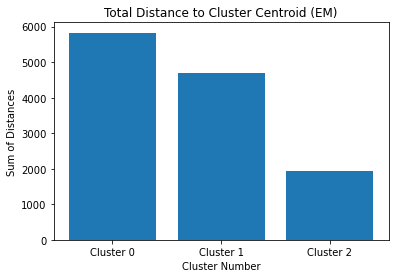

In [269]:
inspect_gmm(gmm, X_proj)

                          0      1       2
price                 150.0  181.0  1050.0
beds                    1.0    3.0     5.0
review_scores_rating  100.0   93.0   100.0
availability_90          90      9      90
amenitites_fire           0      1       1
prop__Entire house        0      1       1
              availability_90  review_scores_rating       price      beds  \
kmeans_label                                                                
0                   29.402445             95.834509  115.496944  1.315468   
1                   30.159015             96.286114  243.534714  3.033035   
2                   46.629386             96.754386  710.250000  7.026316   

              prop__Entire house  amenitites_fire  
kmeans_label                                       
0                       0.085096         0.711801  
1                       0.538634         0.771557  
2                       0.885965         0.857456  


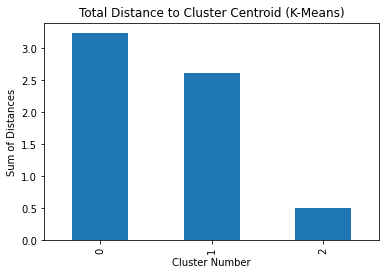

In [272]:
inspect_kmeans(km, X_proj)

In [940]:
amenities_df = filt_df[["amenities"]]

In [941]:
amenities_df.iloc[i]

amenities    [heating, lockbox, cable tv, microwave, dishwa...
Name: 0, dtype: object

In [942]:
all_amenities = []
for i in range(0, len(amenities_df)):
    all_amenities += amenities_df.iloc[i, 0]

In [943]:
L =list(set(all_amenities))

In [944]:
f = lambda x: Counter([y for y in x if y in L])
amenities_df['new'] = (pd.DataFrame(amenities_df['amenities'].apply(f).values.tolist())
               .fillna(0)
               .astype(int)
               .reindex(columns=L)
               .values
               .tolist())

<ipython-input-944-c1cfbb885c8e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [945]:
vec_arr = np.zeros((len(amenities_df), len(L)))

In [946]:
vec_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [947]:
for i in range(0, len(amenities_df)):
    vec_arr[i] = amenities_df['new'].values[i]

In [948]:
vec_arr

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [949]:
X = pd.DataFrame(vec_arr)

In [950]:
X.columns = list(L)

In [951]:
final_df = X.copy()

In [952]:
final_df = pd.DataFrame(final_df)
final_df.columns = list(L)
final_df['price_bin'] = y

In [953]:
problem_two = final_df.copy(deep=True)

In [954]:
X = scaler.fit_transform(X)

In [955]:
SEED = 1928312893

In [909]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)

In [589]:
kmeans_df, gmm_df = run_clustering(X, y)

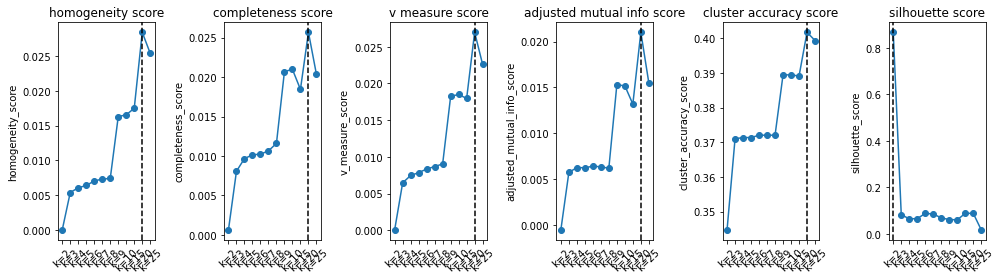

In [590]:
plot_results(kmeans_df)

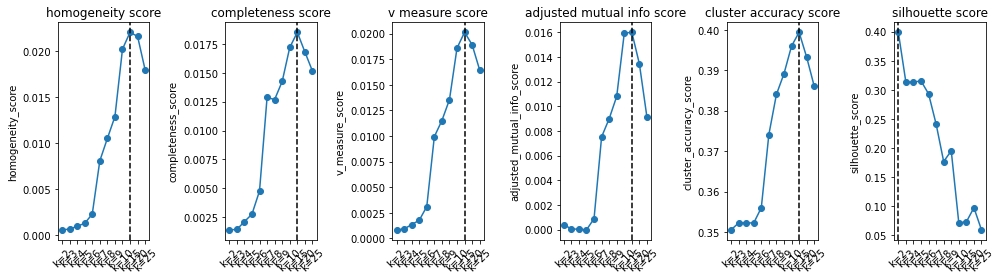

In [591]:
plot_results(gmm_df)

In [789]:
km = kmeans(n_clusters=4, random_state=SEED, init="k-means++", n_init=4)
gmm = GMM(n_components=3, random_state=SEED, n_init=4)

In [790]:
x_labels = ["Cluster {0}".format(x) for x in range(0, gmm.n_components)]

In [791]:
x_labels

['Cluster 0', 'Cluster 1', 'Cluster 2']

In [792]:
def inspect_gmm(gmm, X):
    inspect_df = final_df.copy(deep=True)
    gmm.fit(X)
    min_indices = []
    inspect_df["gmm_label"] = gmm.predict(X)
    centers = np.empty(shape=(gmm.n_components, X.shape[1]))
    for i in range(gmm.n_components):
        density = multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i],allow_singular=True).logpdf(X)
        centers[i, :] = X[np.argmax(density)]
    for i in range(gmm.n_components):
        min_dist = 1
        min_idx = 0
        for j in range(X.shape[0]):
            dist = mahalanobis(centers[i], X[j], inv(gmm.covariances_[i]))
            if (dist < min_dist):
                min_dist = dist
                min_idx = j
        min_indices.append(min_idx)
    ttl_distances = []
    for i in range(gmm.n_components):
        ttl_distances.append(
            sum([mahalanobis(centers[i], x, inv(gmm.covariances_[i])) for x in X[np.array(inspect_df.gmm_label == i)]])
        )
    x_labels = ["{0}".format(x) for x in range(0, gmm.n_components)]
    #ttl_distances = np.array(ttl_distances) / inspect_df.groupby("gmm_label").count().values[:, 0]
    plt.bar(x=x_labels, height=ttl_distances)
    plt.xlabel("Cluster Number")
    plt.ylabel("Normalized Sum of Distances")
    plt.title("Total Distance to Cluster Centroid (EM)")
    min_idx_dfs = []
    for idx in min_indices:
        col_name = inspect_df.iloc[idx, :]["gmm_label"]
        min_idx_df = pd.Series(inspect_df.iloc[idx, :],name=col_name)
        min_idx_dfs.append(pd.DataFrame(min_idx_df))
    min_idx_df = pd.concat(min_idx_dfs,axis=1)
    min_norm_idx_df = pd.DataFrame(scaler.fit_transform(min_idx_df.iloc[1:-3, :]), index=min_idx_df.index[1:-3])
    most_var_cols = min_norm_idx_df.var(axis=1).sort_values(ascending=False)[:gmm.n_components+1].index
    print(min_idx_df[min_idx_df.index.isin(most_var_cols)])
    print(inspect_df.groupby("gmm_label")[most_var_cols].mean())

                     0.0  1.0  2.0
baking sheet         0.0  1.0  1.0
dishwasher           0.0  0.0  1.0
stove                0.0  1.0  1.0
free street parking  0.0  1.0  1.0
           dishwasher  baking sheet     stove  free street parking
gmm_label                                                         
0            0.414147      0.000000  0.436338             0.459639
1            0.775000      0.825000  0.350000             0.900000
2            0.806630      0.555249  0.883978             0.796961


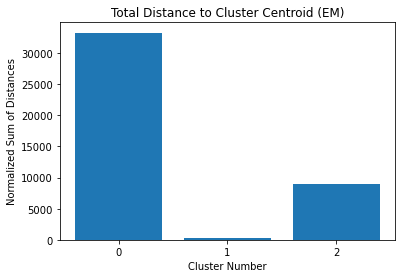

In [793]:
inspect_gmm(gmm, X)

In [794]:
def inspect_kmeans(algo, X):
    inspect_df = final_df.copy(deep=True)
    algo.fit(X)
    X_dist = algo.transform(X)**2
    label = algo.predict(X)
    inspect_df["kmeans_label"] = label
    center_dists = np.array([X_dist[i][x] for i,x in enumerate(label)])
    inspect_df["dist_to_cluster"] = center_dists
    inspect_df["label"] = label
    ttl_distances=inspect_df.groupby("kmeans_label").dist_to_cluster.sum().values
    ttl_counts=inspect_df.groupby("kmeans_label").dist_to_cluster.count().values
    x_labels = ["{0}".format(x) for x in range(0, algo.n_clusters)]
    plt.bar(x=x_labels, height=ttl_distances/ttl_counts)
    plt.xlabel("Cluster Number")
    plt.ylabel("Normalized Sum of Distances")
    plt.title("Total Distance to Cluster Centroid (Kmeans)")
    min_indices = []
    for l in np.unique(algo.labels_):
        X_label_indices = np.where(label==l)[0]
        min_label_idx = X_label_indices[np.argmin(center_dists[label==l])]
        min_indices.append(min_label_idx)
    min_idx_dfs = []
    for idx in min_indices:
        col_name = inspect_df.iloc[idx, :]["kmeans_label"]
        min_idx_df = pd.Series(inspect_df.iloc[idx, :],name=col_name)
        min_idx_dfs.append(pd.DataFrame(min_idx_df))
    min_idx_df = pd.concat(min_idx_dfs,axis=1)
    min_norm_idx_df = pd.DataFrame(scaler.fit_transform(min_idx_df.iloc[1:-3, :]), index=min_idx_df.index[1:-3])
    most_var_cols = min_norm_idx_df.var(axis=1).sort_values(ascending=False)[:km.n_clusters].index
    print(min_idx_df[min_idx_df.index.isin(most_var_cols)])
    print(inspect_df.groupby("kmeans_label")[most_var_cols].mean())

         0.0  1.0  2.0  3.0
dryer    1.0  0.0  1.0  0.0
heating  1.0  0.0  1.0  0.0
wifi     1.0  0.0  1.0  0.0
tv       1.0  0.0  1.0  0.0
               heating     dryer        tv      wifi
kmeans_label                                        
0             0.977787  0.814620  0.909532  0.984249
1             0.000000  0.000000  0.000000  0.000000
2             0.955050  0.775251  0.810153  0.969328
3             0.000000  0.000000  0.000000  0.000000


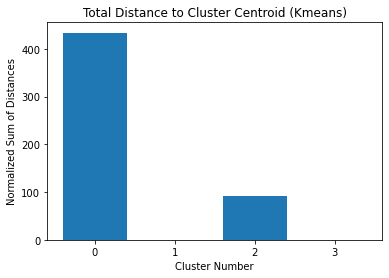

In [795]:
inspect_kmeans(km, X)

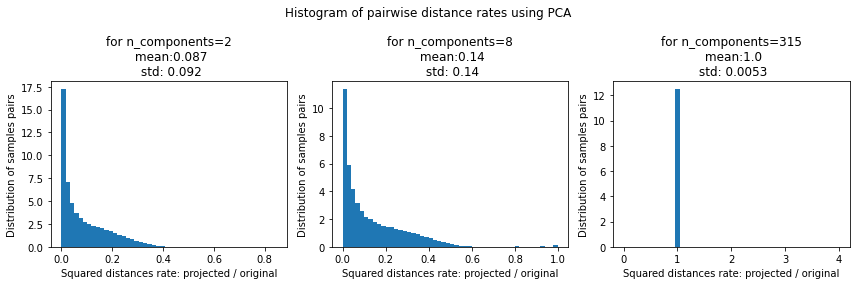

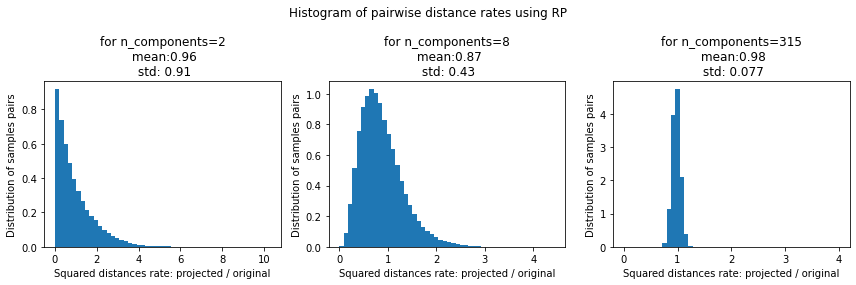

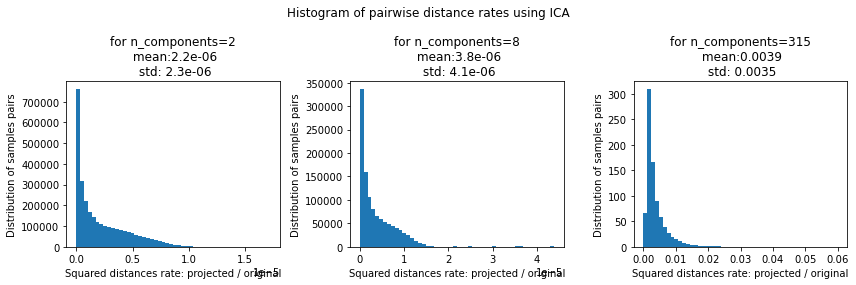

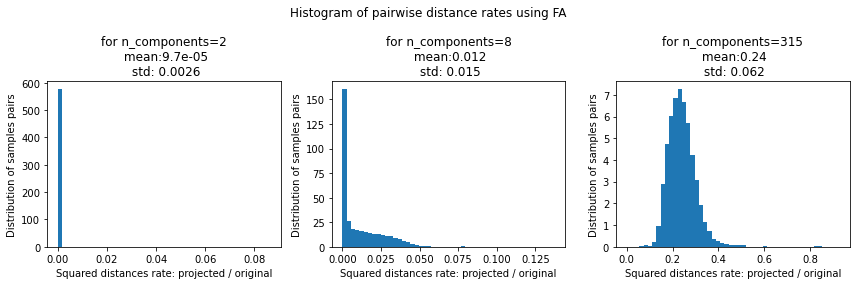

In [910]:
plot_distance_rates(X_train)

In [670]:
from sklearn.linear_model import LogisticRegression

In [956]:
def run_dim_reduction(X, y):
    pca_dfs, ica_dfs, rp_dfs = [], [], []
    rds = {"PCA": PCA(random_state=SEED),
          "RP": GaussianRandomProjection(random_state=SEED),
          "ICA": FastICA(random_state=SEED, max_iter=1000, tol=.1),
          "FA": FactorAnalysis(random_state=SEED)}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
    lr = LogisticRegression(solver='liblinear', random_state=SEED)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    dfs = []
    all_vals = list(range(2, 26))
    all_vals += list(np.arange(30, 300, 25))
    for k in all_vals:
        results = {}
        for name, rd in rds.items():
            rd.set_params(n_components=k)
            X_rd = rd.fit_transform(X)
            X_train, X_test, y_train, y_test = train_test_split(X_rd, y, test_size=.33, random_state=SEED)
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            result_df = pd.DataFrame(results, index=["n_components={0}".format(k)])
        dfs.append(result_df)
    results_df = pd.concat(dfs)
    results_df["All Data"] = [acc]*len(results_df)
    return results_df

In [957]:
results_df = run_dim_reduction(X, y)

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.



In [959]:
results_df.index = [x[1] for x in results_df.index.str.split("=")]

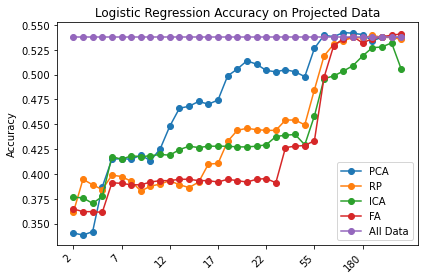

In [960]:
results_df.index = [x[1] for x in results_df.index.str.split("=")]
fig, ax = plt.subplots(figsize=(6, 4))
for col in results_df.columns:
    ax.plot(results_df[[col]], label=col, marker='o')
fig.autofmt_xdate(rotation=45)
ax.legend()
ax.set_ylabel("Accuracy")
ax.set_title("Logistic Regression Accuracy on Projected Data")
ax.set_xticks(np.arange(0, len(results_df), 5)) 
fig.tight_layout()

Text(33.0, 0.5, 'Feature Number')

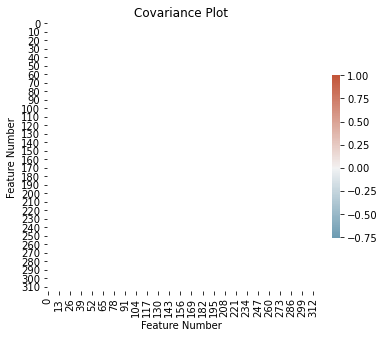

In [686]:
d = pd.DataFrame(X)

# Compute the correlation matrix
corr = d.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Covariance Plot")
ax.set_xlabel("Feature Number")
ax.set_ylabel("Feature Number")

In [656]:
ica = FastICA(random_state=SEED, max_iter=1000, tol=.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
kurts = {}
for k in np.arange(2, 300, 5):
    ica.set_params(n_components=k)
    tmp = ica.fit_transform(X_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurts[k] = tmp.abs().mean()
    
plt.bar(x=kurts.keys(), height=kurts.values())
plt.title('Kurtosis by Component (ICA)')
plt.xlabel("Number of components")
plt.ylabel('Kurtosis')

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning:

FastICA did not converge. Consider

KeyboardInterrupt: 

Text(0, 0.5, 'Kurtosis')

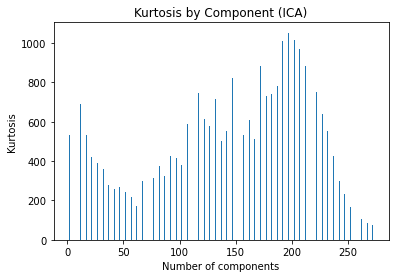

In [666]:
plt.bar(x=kurts.keys(), height=kurts.values())
plt.title('Kurtosis by Component (ICA)')
plt.xlabel("Number of components")
plt.ylabel('Kurtosis')

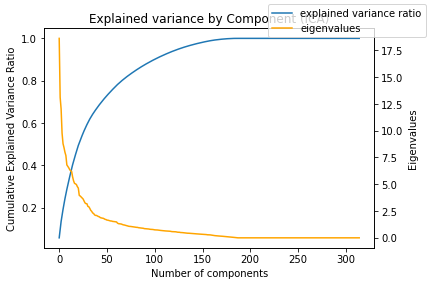

In [654]:
pca = PCA(n_components=X.shape[1], random_state=SEED)
pca.fit(X_train)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(np.arange(0, X.shape[1]), np.cumsum(pca.explained_variance_ratio_), label="explained variance ratio")
ax2.plot(np.arange(0, X.shape[1]), pca.explained_variance_, label="eigenvalues", color="orange")
ax.set_title('Explained variance by Component (ICA)')
ax.set_xlabel("Number of components")
ax.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_ylabel('Eigenvalues')
fig.legend()
fig.tight_layout()

In [762]:
clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]

In [763]:
    rds = {"PCA": PCA(random_state=SEED),
          "RP": GaussianRandomProjection(random_state=SEED),
          "ICA": FastICA(random_state=SEED, max_iter=1000, tol=1)}
    dists = euclidean_distances(X, squared=True).ravel()
    nonzero = dists != 0
    dists = dists[nonzero]
    all_km_dfs = []
    all_gmm_dfs = []
    for name, rd in rds.items():
        rp = rd.set_params(n_components=150)
        projected_data = rp.fit_transform(X)
        kmeans_dfs = []
        gmm_dfs = []
        for n in clusters:
            X_train, X_test, y_train, y_test = train_test_split(projected_data, y, test_size=.33, random_state=SEED)
            kmeans_dfs = [] 
            gmm_dfs = []
            km = kmeans(random_state=SEED, init="k-means++", n_init=4)
            gmm = GMM(random_state=SEED, init_params="kmeans", n_init=4)
            for k in clusters:
                km.set_params(n_clusters=k)
                gmm.set_params(n_components=k)
                km.fit(X_train)
                gmm.fit(X_train)

                km_labels = km.predict(X_train)
                gmm_labels = gmm.predict(X_train)

                kmeans_res = {k:v(y_train, km_labels) for (k,v) in clustering_metrics.items()}
                gmm_res = {k:v(y_train, gmm_labels) for (k,v) in clustering_metrics.items()}
                kmeans_res["silhouette_score"] = silhouette_score(X_train, km_labels)
                gmm_res["silhouette_score"] = silhouette_score(X_train, gmm_labels)
                kmeans_df = pd.DataFrame(kmeans_res, index=["k={0}".format(k)])
                gmm_df = pd.DataFrame(gmm_res, index=["k={0}".format(k)])
                gmm_dfs.append(gmm_df)
                kmeans_dfs.append(kmeans_df)
        gmm_df = pd.concat(gmm_dfs)
        kmeans_df = pd.concat(kmeans_dfs)
        gmm_df["dim_red"] = name
        kmeans_df["dim_red"] = name
        all_km_dfs.append(kmeans_df)
        all_gmm_dfs.append(gmm_df)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


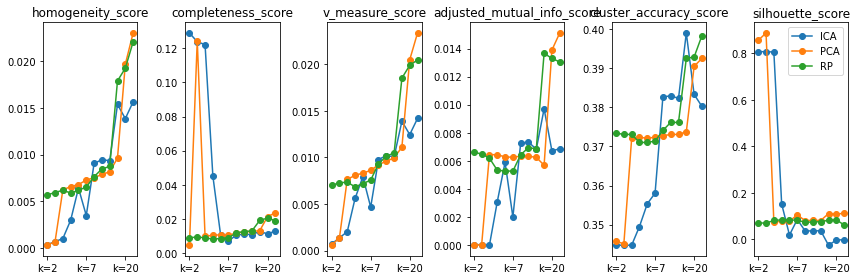

In [764]:
all_km_df = pd.concat(all_km_dfs)
all_gmm_df = pd.concat(all_gmm_dfs)

fig, axes = plt.subplots(ncols=6, figsize=(12, 4))
for i, score in enumerate(all_km_df.columns[:-1]):
    for dim_red in ["ICA", "PCA", "RP"]:
        all_km_df[all_km_df.dim_red == dim_red][score].plot(label=dim_red, marker="o", ax=axes[i])
        plt.legend()
        axes[i].set_title(score)
fig.tight_layout()

In [799]:
all_km_df[all_km_df.dim_red == "PCA"]

,homogeneity_score,completeness_score,v_measure_score,adjusted_mutual_info_score,cluster_accuracy_score,silhouette_score,dim_red
k=2,0.000312,0.004645,0.000584,-0.000009,0.345746,0.856344,PCA
k=3,0.000695,0.124296,0.001382,0.000023,0.345063,0.887803,PCA
k=4,0.006237,0.009925,0.007660,0.006446,0.372053,0.076176,PCA
k=5,0.006571,0.010413,0.008058,0.006429,0.372395,0.077470,PCA
k=6,0.006801,0.010743,0.008329,0.006287,0.372053,0.078541,PCA
k=7,0.007275,0.010494,0.008593,0.006251,0.372395,0.105628,PCA
k=8,0.007539,0.011811,0.009203,0.006338,0.372737,0.081049,PCA
k=9,0.007873,0.012285,0.009596,0.006322,0.373078,0.082177,PCA
k=10,0.008163,0.012686,0.009933,0.006250,0.373078,0.081381,PCA
k=15,0.009634,0.013104,0.011104,0.005687,0.373762,0.111343,PCA


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


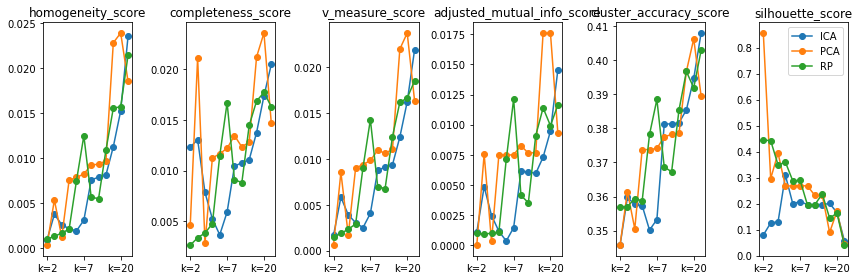

In [765]:
fig, axes = plt.subplots(ncols=6, figsize=(12, 4))
for i, score in enumerate(all_gmm_df.columns[:-1]):
    for dim_red in ["ICA", "PCA", "RP"]:
        all_gmm_df[all_gmm_df.dim_red == dim_red][score].plot(label=dim_red, marker="o", ax=axes[i])
        plt.legend()
        axes[i].set_title(score)
fig.tight_layout()

In [797]:
all_gmm_df[all_gmm_df.dim_red == "PCA"]

,homogeneity_score,completeness_score,v_measure_score,adjusted_mutual_info_score,cluster_accuracy_score,silhouette_score,dim_red
k=2,0.000312,0.004645,0.000584,-0.000009,0.345746,0.856344,PCA
k=3,0.005352,0.021129,0.008541,0.007544,0.361462,0.296333,PCA
k=4,0.001224,0.002835,0.001710,0.000320,0.350530,0.394258,PCA
k=5,0.007537,0.011229,0.009020,0.007492,0.373762,0.267114,PCA
k=6,0.007856,0.011665,0.009389,0.007458,0.373762,0.268395,PCA
k=7,0.008241,0.012195,0.009835,0.007502,0.374103,0.269441,PCA
k=8,0.009250,0.013454,0.010963,0.008249,0.377520,0.267781,PCA
k=9,0.009324,0.012330,0.010618,0.007631,0.378203,0.231302,PCA
k=10,0.009714,0.012817,0.011052,0.007682,0.378545,0.231538,PCA
k=15,0.022851,0.021227,0.022009,0.017606,0.396652,0.089341,PCA


In [805]:
pca = PCA(n_components=150, random_state=SEED)
X_proj = pca.fit_transform(X)
gmm = GMM(n_components=3, random_state=SEED, init_params="kmeans", n_init=4)
km = kmeans(n_clusters=2, random_state=SEED, init="k-means++", n_init=4)

                     0.0  0.0  2.0
bedroom comforts     0.0  0.0  1.0
bathroom essentials  0.0  0.0  1.0
self check-in        0.0  0.0  1.0
full kitchen         0.0  0.0  1.0
           full kitchen  self check-in  bathroom essentials  bedroom comforts
gmm_label                                                                    
0              0.000000       0.000000                  0.0               0.0
1              0.000000       0.000000                  0.0               0.0
2              0.714932       0.773756                  1.0               1.0


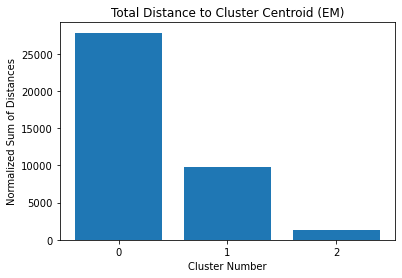

In [806]:
inspect_gmm(gmm, X_proj)

                         0.0  1.0
luggage dropoff allowed  0.0  1.0
oven                     0.0  1.0
                  oven  luggage dropoff allowed
kmeans_label                                   
0             0.031283                 0.058324
1             0.876359                 0.363270


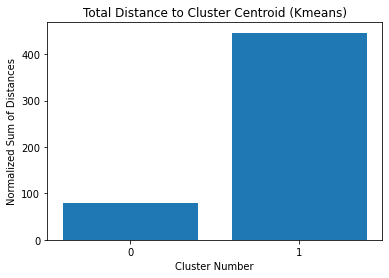

In [807]:
inspect_kmeans(km, X_proj)

In [ ]:
 tv     dryer      wifi  air conditioning  heating  free parking on premises   shampoo  refrigerator

In [774]:
X_train, X_test, y_train, y_test = train_test_split(X_proj, y, test_size=.33, random_state=SEED)

In [776]:
km.fit(X_proj)
gmm.fit(X_proj)
km_labels = km.predict(X_proj)
gmm_labels = gmm.predict(X_proj)

In [808]:
import six
#https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np
import time
import matplotlib.pyplot as plt
import random

In [809]:
import time
from sklearn.metrics import accuracy_score
import mlrose

In [828]:
X_p1 = problem_one[problem_one.columns[1:-1]]
X_p1 = scaler.fit_transform(X_p1)
y = problem_one.price_bin

In [834]:
set(y)

{0, 1, 2}

In [829]:
X_p2 = problem_two[problem_two.columns[:-1]]
X_p2 = scaler.fit_transform(X_p2)

In [835]:
X_train, X_test, y_train, y_test = train_test_split(X_p1, y, test_size=.33, random_state=SEED)

In [837]:
set(y_test)

{0, 1, 2}

In [840]:
from sklearn.neural_network import MLPClassifier

In [971]:
from tqdm import tqdm

In [1011]:
def run_dim_reduction(X, y):
    pca_dfs, ica_dfs, rp_dfs = [], [], []
    time_dfs = []
    rds = {"PCA": PCA(random_state=SEED),
          "RP": GaussianRandomProjection(random_state=SEED),
          "ICA": FastICA(random_state=SEED, max_iter=1000, tol=.1),
          "FA": FactorAnalysis(random_state=SEED)}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
    lr = MLPClassifier(random_state=SEED, alpha=.01, max_iter=500)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    dfs = []
    all_vals = list(range(2, 26))
    all_vals += list(np.arange(30, 300, 25))
    for k in tqdm(all_vals):
        results = {}
        times = {}
        for name, rd in rds.items():
            start = time.process_time()
            rd.set_params(n_components=k)
            X_rd = rd.fit_transform(X)
            time.process_time()
            X_train, X_test, y_train, y_test = train_test_split(X_rd, y, test_size=.33, random_state=SEED)
            lr.fit(X_train, y_train)
            end = time.process_time()
            y_pred = lr.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            ttl_time = end - start
            times[name] = ttl_time
            result_df = pd.DataFrame(results, index=["n_components={0}".format(k)])
            time_df = pd.DataFrame(times, index=["n_components={0}".format(k)])
        dfs.append(result_df)
        time_dfs.append(time_df)
    results_df = pd.concat(dfs)
    time_df = pd.concat(time_dfs)
    results_df["All Data"] = [acc]*len(results_df)
    return results_df, time_df

In [1013]:
results_dr_df, time_dr_df = run_dim_reduction(X_p2, y)

 31%|███▏      | 11/35 [01:44<04:47, 11.99s/it]/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

 34%|███▍      | 12/35 [02:02<05:14, 13.66s/it]/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

 40%|████      | 14/35 [02:38<05:35, 15.97s/it]/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

 43%|████▎     | 15/35 [02:55<05:23, 16.17s/it]/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: Conv

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

100%|██████████| 35/35 [14:33<00:00, 24.97s/it]


<AxesSubplot:title={'center':'Average Decomp + Train Time'}, ylabel='Decomp + Train Time'>

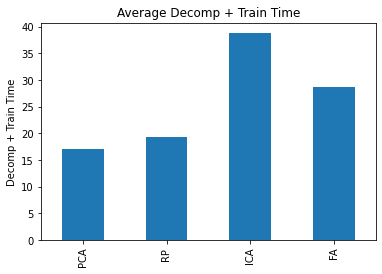

In [1026]:
time_dr_df.mean().plot(kind="bar", title="Average Decomp + Train Time", ylabel="Decomp + Train Time")

In [1028]:
results_dr_df

,PCA,RP,ICA,FA,All Data
n_components=2,0.426491,0.372399,0.334951,0.395284,0.506241
n_components=3,0.448682,0.385576,0.352288,0.391123,0.506241
n_components=4,0.449376,0.398752,0.375173,0.387656,0.506241
n_components=5,0.463245,0.418169,0.411928,0.389736,0.506241
n_components=6,0.468100,0.429265,0.415395,0.419556,0.506241
n_components=7,0.457004,0.430652,0.441748,0.418169,0.506241
n_components=8,0.468793,0.447295,0.436200,0.431345,0.506241
n_components=9,0.468100,0.441054,0.420943,0.425798,0.506241
n_components=10,0.482663,0.440361,0.427184,0.418863,0.506241
n_components=11,0.466713,0.439667,0.458391,0.418169,0.506241


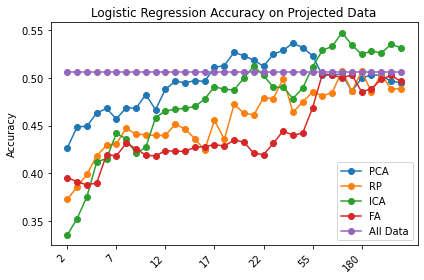

In [975]:
results_df.index = [x[1] for x in results_df.index.str.split("=")]
fig, ax = plt.subplots(figsize=(6, 4))
for col in results_df.columns:
    ax.plot(results_df[[col]], label=col, marker='o')
fig.autofmt_xdate(rotation=45)
ax.legend()
ax.set_ylabel("Accuracy")
ax.set_title("Logistic Regression Accuracy on Projected Data")
ax.set_xticks(np.arange(0, len(results_df), 5)) 
fig.tight_layout()

In [985]:
def run_clustering(X, y):
    pca_dfs, ica_dfs, rp_dfs = [], [], []
    rds = {"km": kmeans(random_state=SEED, init="k-means++", n_init=4),
          "RP": GMM(random_state=SEED, init_params="kmeans", n_init=4)}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
    lr = MLPClassifier(random_state=SEED, alpha=.01, max_iter=500)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    dfs = []
    all_vals = list(range(2, 26))
    for k in tqdm(all_vals):
        results = {}
        for name, rd in rds.items():
            if name == "km":
                rd.set_params(n_clusters=k)
            else:
                rd.set_params(n_components=k)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)
            rd.fit(X_train)
            labels = rd.predict(X_train)
            clustering_df = pd.get_dummies(labels)
            lr.fit(clustering_df, y_train)
            labels = rd.predict(X_test)
            clustering_df = pd.get_dummies(labels)
            y_pred = lr.predict(clustering_df)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            result_df = pd.DataFrame(results, index=["n_components={0}".format(k)])
        dfs.append(result_df)
    results_df = pd.concat(dfs)
    results_df["All Data"] = [acc]*len(results_df)
    return results_df

In [1092]:
    rds = {"km": kmeans(random_state=SEED, init="k-means++", n_init=4),
          "RP": GMM(random_state=SEED, init_params="kmeans", n_init=4)}
    lr = MLPClassifier(random_state=SEED, alpha=.01, max_iter=500)
    dfs = []
    time_dfs = []
    speed_dfs = []
    all_vals = list(range(2, 26))
    for k in tqdm(all_vals):
        results = {}
        times = {}
        for name, rd in rds.items():
            if name == "km":
                rd.set_params(n_clusters=k)
            else:
                rd.set_params(n_components=k)
            start = time.process_time()
            rd.fit(X_p2)
            labels = rd.predict(X_p2)
            clustering_df = pd.get_dummies(labels)
            X_train, X_test, y_train, y_test = train_test_split(clustering_df, y, test_size=.33, random_state=SEED)
            lr.fit(X_train, y_train)
            end = time.process_time()
            y_pred = lr.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            times[name] = end - start
            result_df = pd.DataFrame(results, index=["n_components={0}".format(k)])
            time_df = pd.DataFrame(times, index=["n_components={0}".format(k)])
        dfs.append(result_df)
        time_dfs.append(time_df)
    results_df = pd.concat(dfs)

100%|██████████| 24/24 [08:25<00:00, 21.07s/it]


In [1093]:
time_df = pd.concat(time_dfs)

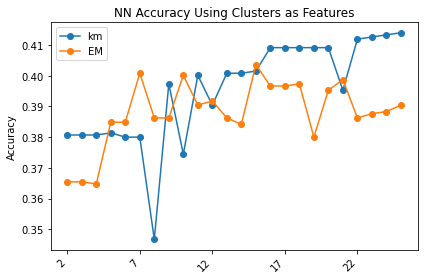

In [1007]:
#results_df.index = [x[1] for x in results_df.index.str.split("=")]
fig, ax = plt.subplots(figsize=(6, 4))
for col in results_df.columns:
    if col == "RP":
        col_label="EM"
        ax.plot(results_df[[col]], label=col_label, marker='o')
    else:
        ax.plot(results_df[[col]], label=col, marker='o')
fig.autofmt_xdate(rotation=45)
ax.legend()
ax.set_ylabel("Accuracy")
ax.set_title("NN Accuracy Using Clusters as Features")
ax.set_xticks(np.arange(0, len(results_df), 5)) 
fig.tight_layout()

In [1096]:
time_df.columns = ["KM", "EM"]

<AxesSubplot:title={'center':'Average Clustering + Train Time'}, ylabel='Clustering + Train Time'>

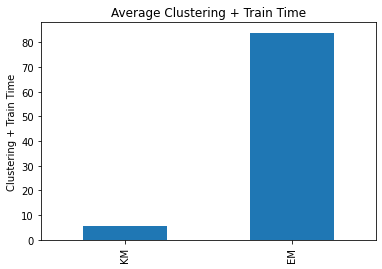

In [1099]:
time_df.mean().plot(kind="bar", title="Average Clustering + Train Time", ylabel="Clustering + Train Time")

In [1029]:
pca = PCA(n_components=150, random_state=SEED)

In [1031]:
X_pca_trans = pca.fit_transform(X_p2)

In [1039]:
X_p1.shape

(4369, 40)

In [1072]:
X_p1_na = problem_one[problem_one.columns[1:-1]]

In [1073]:
X_p1_na = scaler.fit_transform(X_p1_na)

In [1080]:
lr = MLPClassifier(random_state=SEED, alpha=.01, max_iter=500)

In [1081]:
X_train, X_test, y_train, y_test = train_test_split(X_p1_na, y, test_size=.33, random_state=SEED)

In [1082]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9521497919556172


In [1083]:
full_X = pd.concat([pd.DataFrame(X_p1_na), pd.DataFrame(X_pca_trans)], axis=1)

In [1084]:
X_train, X_test, y_train, y_test = train_test_split(full_X, y, test_size=.33, random_state=SEED)

In [1085]:
lr = MLPClassifier(random_state=SEED, alpha=.01, max_iter=500)

In [1086]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8925104022191401


In [1087]:
km.set_params(n_clusters=4)

KMeans(n_clusters=4, n_init=4, random_state=1928312893)

In [1088]:
km.fit(X_pca_trans)

KMeans(n_clusters=4, n_init=4, random_state=1928312893)

In [1089]:
full_X['km_labels']=km.predict(X_pca_trans)

In [1090]:
X_train, X_test, y_train, y_test = train_test_split(full_X, y, test_size=.33, random_state=SEED)

In [1091]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8876560332871013
